# Supercomputing - Assignment 15

## Developed by Camilo Salcedo for HAS-Tools in Fall 2020
### December 7/2020


## Package import



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter
import datetime as dt
from sklearn.linear_model import LinearRegression
import os



## Functions

In [3]:
def AR_model_estimate(df, initial_train_date, final_train_date, time_shifts):
    """ Estimate the parameters of an Auto Regressive Model (AR)

    Parameters:
    ----------
    df: Dataframe containing the flow information.
    initial_date: Initial date for the training period in format 'YYYY-MM-DD'.
    final_date: Final date for the training period in format 'YYYY-MM-DD'.
    time_shifts: Number of time shifts to consider in the AR model.

    Returns:
    ---------
    model_intercept: The intercept of the AR Model
    model_coefficients: The coefficients of the AR Model (size=[time_shifts,1])
    r_sq: Determination Coefficient R2 of the AR Model
    """

    # Define the type of model to use
    model_LR = LinearRegression()

    # Start the shift listing with the string 'Flow'
    shift_list = ['flow']

    # Create additional columns to the dataframe to include desired time \
    # shifts
    for i in range(1, time_shifts+1):
        num_shift = 'flow_tm'+str(i)
        df[num_shift] = df['flow'].shift(i)
        shift_list.append(num_shift)

    # Create a dataframe of training data including all columns of df
    train_data = df[initial_train_date:final_train_date][shift_list]

    # Create the dependent array for the AR model
    y_data = train_data['flow']

    # Create the set of independent variables for the AR Model.
    x_data = train_data[shift_list[1:len(shift_list)]]

    # Fit the corresponding AR Model
    model_LR.fit(x_data, y_data)

    # Save the results of the AR Model
    r_sq = np.round(model_LR.score(x_data, y_data), 4)
    model_intercept = np.round(model_LR.intercept_, 2)
    model_coefficients = np.round(model_LR.coef_, 2)

    # Print the results to the user
    print('AR Model with ', time_shifts, ' shifts')
    print('coefficient of determination:', r_sq)
    print('intercept:', model_intercept)
    print('slope:', model_coefficients)

    return model_intercept, model_coefficients, r_sq

#### Flow Data Retrieving:

In [7]:
def forecast_flows(flow_daily, time_shifts, start_train_date, end_train_date,
                   start_for_date, end_for_date, seasonal):
    """ Forecast the flows for a given number of periods based on flow timeseries

    Parameters:
    -----------
    flow_daily: Dataframe containing the daily flow information. The index of \
            the df should be the date and this df should only include 'flow'.
    time_shifts: Number of time shifts to consider in the AR Model
    start_train_date: Initial date for the training period in format
                      'YYYY-MM-DD'.
    end_train_date: Final date for the training period in format 'YYYY-MM-DD'.
    start_for_date: Initial date for the forecast in format 'YYYY-MM-DD'.
    end_for_date: Final date for the forecast in format 'YYYY-MM-DD'.
    seasonal: Binary condition telling the scale of time of the forecast.

    Returns:
    -----------
    flow_daily: Dataframe with the forecasts in a daily basis
    flow_weekly: Dataframe with the forecasts in a weekly basis
    model_intercept: Intercept from the AR Model
    model_coefficients: List of coefficients from the AR Model
    """

    # Get the location (index) for the day before the start forecasting \
    # date in the original dataframe (data)

    temp_data = flow_daily
    temp_data = temp_data.reset_index()
    temp_data['datetime'] = flow_daily.index  # .strftime('%Y-%m-%d')

    if seasonal == 'week':
        date_before_start = (pd.to_datetime(start_for_date) +
                             dt.timedelta(days=-1)).date()
        index_lag1 = temp_data.loc[temp_data.datetime == str(
            date_before_start)].index[0]
    elif seasonal == 'seasonal':
        flow_daily = flow_daily.resample("W-SUN", closed='left', label='left')\
            .mean()
        index_lag1 = flow_daily.shape[0]-1
        print(index_lag1)
    else:
        print('Please choose a valid time horizon for forecast')

    # Create a list of dates (daily) for the forecast period
    if seasonal == 'week':
        forecast_period = pd.date_range(start=start_for_date,
                                        end=end_for_date, freq='D')
    elif seasonal == 'seasonal':
        forecast_period = pd.date_range(start=start_for_date,
                                        end=end_for_date, freq='W')

    # Estimate the parameters for the best-fit AR Model
    model_intercept, model_coefficients, r_sq = AR_model_estimate(
        flow_daily, start_train_date, end_train_date, time_shifts)

    # Calculate the Forecasts for the indicated time range based on the \
    # selected timeshifts.
    # "lag_i" is used to extract the flow value based on the order of the \
    # AR Model using the index located for the day before the start of \
    # forecast.
    lag_i = index_lag1+1

    # Initialize the variable for the forecasts
    forecast_val = 0

    # Using two loops, the forecasts are calculated between \
    # the desired range of dates, and then appended to the dataframe

    for i in range(0, forecast_period.shape[0]):
        for k in range(0, time_shifts):
            forecast_val += model_coefficients[k] * \
                flow_daily.iloc[lag_i-(k+1)]['flow']
        forecast_val += model_intercept
        lag_i += 1
        flow_daily.loc[forecast_period[i], ['flow']] = forecast_val
        forecast_val = 0

    # Resampling the forecast in a weekly basis, starting on Sundays and \
    # setting the labels and closed interval at the left
    if seasonal == 'week':
        flow_weekly = flow_daily.loc[start_for_date:end_for_date][['flow']].\
            resample("W-SUN", closed='left', label='left').mean()
    elif seasonal == 'seasonal':
        flow_weekly = flow_daily.loc[start_for_date:end_for_date][['flow']]

    # Print the forecasts for the competition
    for i in range(flow_weekly.shape[0]):
        print('\n Week #', str(i+1), '-', flow_weekly.iloc[i].name, '(cfs): ',
              np.round(flow_weekly.iloc[i]['flow'], 2))

    return flow_daily, flow_weekly, model_intercept, model_coefficients

In [8]:
# %% Data Retrieval for Stremflow (USGS)

# URL Variables
site = '09506000'
start = '1989-01-01'  # Adjusted according to information availability
end = '2020-12-05'
url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=" + \
    site + "&referred_module=sw&period=&begin_date=" + start + "&end_date=" +\
    end

stream_data = pd.read_table(url, skiprows=30, names=['agency_cd', 'site_no',
                                                     'datetime', 'flow',
                                                     'code'],
                            parse_dates=['datetime'], index_col='datetime')

stream_data.index = stream_data.index.strftime('%Y-%m-%d')
stream_data = stream_data.set_index(pd.to_datetime(stream_data.index))

### Results of the Forecasts

The results after running the AR models described before are presented. First, the weekly forecasts and then the seasonal results.

#### Weekly Results


In [13]:
# Common dataframe for both forecasts including only the flow column
daily_flow = stream_data[['flow']]
daily_flow = daily_flow.set_index(pd.to_datetime(stream_data.index))

# Two-week forecast

# Training period for the AR Model
start_train_date = '2017-11-01'
end_train_date = '2017-12-12'

# Forecasting period
start_for_date = '2020-12-06'
end_for_date = '2020-12-19'

# Used parameters for the model
# Number of shifts
time_shifts = 3

# Function Call
flow_daily_2w, flow_weekly_2w, model_intercept, model_coefficients = \
    forecast_flows(daily_flow, time_shifts, start_train_date,
                       end_train_date, start_for_date, end_for_date, 'week')

AR Model with  3  shifts
coefficient of determination: 0.9819
intercept: 5.18
slope: [ 0.99 -0.28  0.27]

 Week # 1 - 2020-12-06 00:00:00 (cfs):  167.58

 Week # 2 - 2020-12-13 00:00:00 (cfs):  177.18


#### Seasonal Results

In [9]:
# Seasonal Forecast for weeks between Aug. 22 to Oct. 31

# Training period for the AR Model for first 6 weeks
start_train_date = '2017-08-25'
end_train_date = '2017-11-17'

# Forecasting period for first 6 weeks
start_for_date = '2020-08-22'
end_for_date = '2020-10-31'

# Number of shifts
time_shifts = 3

# Common dataframe for both forecasts including only the flow column
daily_flow_16w_1 = stream_data.loc['1989-01-01':start_for_date][['flow']]

# Function Call
flow_daily_seas1, flow_weekly_seas1, model_intercept16_1, \
    model_coefficients16_1 = forecast_flows(daily_flow_16w_1, time_shifts,
                                                start_train_date, end_train_date, start_for_date, end_for_date,
                                                'seasonal')


1650
AR Model with  3  shifts
coefficient of determination: 0.8561
intercept: 9.25
slope: [ 1.32 -0.31 -0.06]

 Week # 1 - 2020-08-23 00:00:00 (cfs):  42.34

 Week # 2 - 2020-08-30 00:00:00 (cfs):  52.05

 Week # 3 - 2020-09-06 00:00:00 (cfs):  62.71

 Week # 4 - 2020-09-13 00:00:00 (cfs):  73.35

 Week # 5 - 2020-09-20 00:00:00 (cfs):  83.5

 Week # 6 - 2020-09-27 00:00:00 (cfs):  92.98

 Week # 7 - 2020-10-04 00:00:00 (cfs):  101.69

 Week # 8 - 2020-10-11 00:00:00 (cfs):  109.65

 Week # 9 - 2020-10-18 00:00:00 (cfs):  116.88

 Week # 10 - 2020-10-25 00:00:00 (cfs):  123.45


In [10]:
# Seasonal Forecast for weeks between Nov. 01 to Dec. 12
# NOTE: I did not use the outputs printed by the model to make the forecasts.\
# Rather, I used the model determined by the function.

# Training period for the AR Model for first 6 weeks
start_train_date = '2017-10-01'
end_train_date = '2017-12-15'

# Forecasting period for first 6 weeks
start_for_date = '2020-11-01'
end_for_date = '2020-12-12'

# Number of shifts
time_shifts = 3

# Common dataframe for both forecasts including only the flow column
daily_flow_16w_2 = flow_daily_seas1.loc['1989-01-01':start_for_date][['flow']]

# Function Call
flow_daily_seas2, flow_weekly_seas2, model_intercept16_2, model_coefficients16_2 = \
    forecast_flows(daily_flow_16w_2, time_shifts, start_train_date,
                       end_train_date, start_for_date, end_for_date, 'seasonal')

1660
AR Model with  3  shifts
coefficient of determination: 0.9886
intercept: 11.26
slope: [ 0.94  0.55 -0.54]

 Week # 1 - 2020-11-01 00:00:00 (cfs):  132.37

 Week # 2 - 2020-11-08 00:00:00 (cfs):  140.47

 Week # 3 - 2020-11-15 00:00:00 (cfs):  149.45

 Week # 4 - 2020-11-22 00:00:00 (cfs):  157.52

 Week # 5 - 2020-11-29 00:00:00 (cfs):  165.67

 Week # 6 - 2020-12-06 00:00:00 (cfs):  172.92


### Performance of the Forecasts

#### Weekly Forecasts


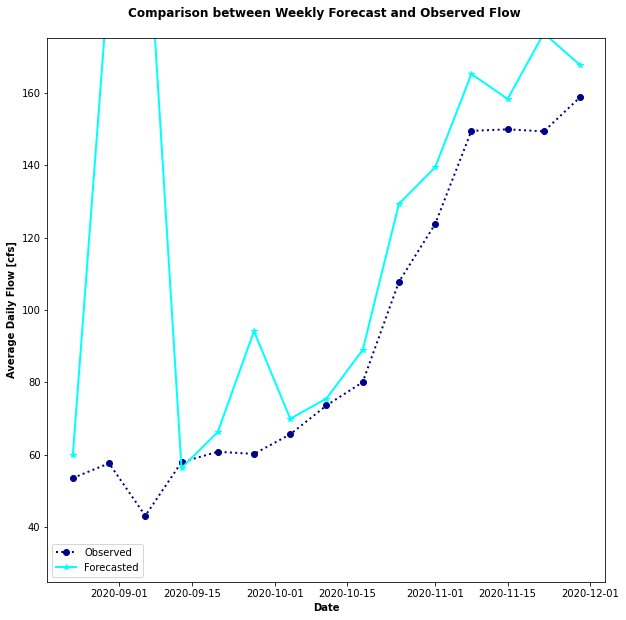

In [11]:
# Plot the Weekly Forecasts against the observed values
week_obs=stream_data.loc['2020-08-23':'2020-12-05'][['flow']].\
            resample("W-SUN", closed='left', label='left').mean()
weekly_for = [60, 192.61, 218.38, 56.39, 66.34, 94.16, 70, 75.57, 88.98, 129.29, 139.39, 165.12, 158.23,176.37, 167.58]

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(week_obs['flow'], color='darkblue', linewidth=2, ls=':',
        marker='o', label='Observed')
ax.plot(week_obs.index, weekly_for, color='cyan', linewidth=2,
        marker='*', label='Forecasted')
ax.set_ylabel('Average Daily Flow [cfs]', fontweight='bold')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylim([25,175])
ax.set_title('Comparison between Weekly Forecast and Observed Flow \n',
    fontweight='bold')
ax.legend()

#### Seasonal Forecasts
  

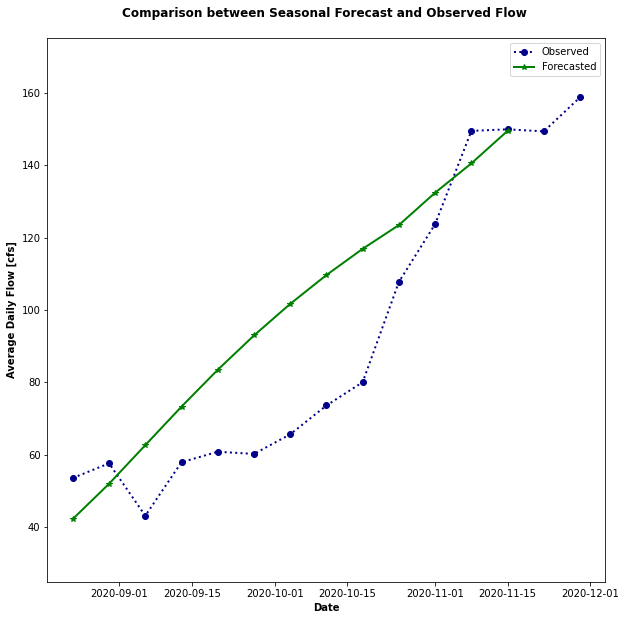

In [12]:
# Plot the Seasonal Forecasts against the observed values
week_obs=stream_data.loc['2020-08-23':'2020-12-05'][['flow']].\
            resample("W-SUN", closed='left', label='left').mean()
seasonal_for = flow_weekly_seas1.append(flow_weekly_seas2)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(week_obs['flow'], color='darkblue', linewidth=2, ls=':',
        marker='o', label='Observed')
ax.plot(seasonal_for.loc['2020-08-23':'2020-11-15']['flow'], color='green', linewidth=2,
        marker='*', label='Forecasted')
ax.set_ylabel('Average Daily Flow [cfs]', fontweight='bold')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylim([25,175])
ax.set_title('Comparison between Seasonal Forecast and Observed Flow \n',
    fontweight='bold')
ax.legend()
